# RTS Data Processing


In this document, the RTS data will be analyzed to help create a larger picture of the communication between the swiss political parties and the public. First, the RTS archives were quieried from 2010 to 2019 with several different quereies shown below. These queries were then combined and refined to see broadcasts where swiss political parties were discussed.

In [1]:
import json
import tokenize
import numpy as np
import pandas as pd
import os
import re
from itertools import islice


BASE_PATH ='data/RTS_dataset_per_year/{}/{}'
parties = r"\bUDC\b|\bVerts\b|\bPS\b|\bPDC\b|\bPLR\b|\bPES\b|Vert lib|Vert'lib|Verte lib|Vert-lib|Verts lib|Verts-lib|Verte-lib|\bVerte\b|\bVert\b|\bPVL\b|\bPSS\b|\bSocialiste\b|\blibéral radical\b|\blibérale radical|\blibéral-radical\b|\blibérale-radical|démocrate chrétien|union démocratique du centre"
thematicGeographicals = r'Geneve|Suisse|Valais|Berne|Zurich|Vaud|Fribourg|Neuchatel|Sion|canton|Bale|Vevey|Jura|Montreux|Bienne|GRUYÈRE|Lucerne|TESSIN|Winterthour|Lugano'
thematicThemes = r"DÉBAT|POLITIQUE|LÉGISLATIF|élection|exécutif|conseiller|initiative populaire|votation|référendum|PRÉSIDENT|Vote|CANDIDAT|CAMPAGNE"
YEARS = np.arange(2010, 2020)

In [2]:
#Next, we want to go year by year and find interviews that are with interviews of political parties
party_dict =[]
contributor_dict = []


def read_in(party):   
    
    for year in YEARS:
        if os.path.exists(BASE_PATH.format(year, party)):
            files = [f for f in os.listdir(BASE_PATH.format(year, party))]
            for file in files:
                with open(BASE_PATH.format(year, party)+"/{}".format(file), 'r', encoding='utf-8') as fp:
                    dicts = json.load(fp)
                    for entry in dicts['data']:
                        
                        #Here we will build a dictionary for looking at the contributors of RTS
                        if 'contributors' in entry and 'publicationDate' in entry:
                            contributor_dict.append(entry)
                        
                        #Here we are filtering through the json to build documents for the topic extraction
                        if {'speechToTexts', 'subTitles', 'summary'}.intersection(entry) and 'publicationDate' in entry:
                            if 'genres' in entry:
                                if 'Interview' in entry['genres']:
                                    if 'thematicGeographicals' in entry:
                                        for place in entry['thematicGeographicals']:
                                            if re.search(thematicGeographicals,place, re.I):
                                                party_dict.append(entry)
                                    else:
                                        party_dict.append(entry)
                            if 'thematicThemes' in entry and 'thematicGeographicals' in entry:
                                for place in entry['thematicGeographicals']:
                                    if re.search(thematicGeographicals, place, re.I):
                                        for theme in entry['thematicThemes']:
                                            if re.search(thematicThemes, theme, re.I):
                                                party_dict.append(entry)
                            if 'title' in entry:
                                if re.search(parties, entry['title'], re.I):
                                    party_dict.append(entry)
                            if 'thematicPersons' in entry: 
                                for person in entry['thematicPersons']:
                                    if re.search(parties, person, re.I):
                                        party_dict.append(entry)
                            if 'chapters' in entry:
                                for chapter in entry['chapters']:
                                    if 'excerpt' in chapter:
                                        if re.search(parties, chapter['excerpt'], re.I):
                                            party_dict.append(chapter)
                                        if 'thematicThemes' in chapter and 'thematicGeographicals' in chapter:
                                            for place in chapter['thematicGeographicals']:
                                                type(place)
                                                if re.search(thematicGeographicals, place, re.I):
                                                    for theme in chapter['thematicThemes']:
                                                        if re.search(thematicThemes, theme, re.I):
                                                            party_dict.append(chapter)

    return 

#For each party, convert the json into dictionaries

read_in('UDC')
read_in('PDC')
read_in('PS')
read_in('PLR')
read_in('PES')
read_in('PVL')
read_in('Verts')
read_in('Politque')

The above function reads in the RTS archive data, taking into account the location, title, theme and genre of the broadcast to build a dictionary consisting of the metadata of these broadcasts and in particular the textual data consisting of the speechToText, subTitles, excerpt or summary of the data.

In [3]:
all_party_topic = pd.DataFrame.from_dict(party_dict)
all_party_contributor = pd.DataFrame.from_dict(contributor_dict)

This next part is to gather all textual data into a single 'text' column

In [9]:
#Converting all possible sources of text to one column
year = all_party_topic["publicationDate"].str[:4]
all_party_topic['year'] = year
all_party_topic['text'] = all_party_topic.apply(lambda x: x['subTitles'] if x['speechToTexts'] == None else x['speechToTexts'], axis=1)
all_party_topic['text'] = all_party_topic.apply(lambda x: x['excerpt'] if x['text'] == None else x['text'], axis=1)
all_party_topic['text'] = all_party_topic.apply(lambda x: x['summary'] if x['text'] == None else x['text'], axis=1)

In [10]:
year = all_party_contributor["publicationDate"].str[:4]
all_party_contributor['year'] = year

In [11]:
#Drop any duplicates
print(len(all_party_contributor))
all_party_contributor= all_party_contributor.drop_duplicates('internalArchiveId')
print(len(all_party_contributor))

print(len(all_party_topic))
all_party_topic= all_party_topic.drop_duplicates('internalArchiveId')
print(len(all_party_topic))

31306
17995
35129
9112


In [12]:
all_party_topic = all_party_topic.dropna(subset=['text', 'publicationDate'])
len(all_party_topic)

3201

Below we will be looking at the number of times a representative from each party is a contributor on RTS. This will help us to understand the information each party is able to convey to the general public.

In [ ]:
all_party_contributor = all_party_contributor[['contributors', 'publicationDate', 'year', 'internalArchiveId']]


In [ ]:
all_party_contributor = all_party_contributor[['contributors', 'publicationDate', 'year', 'internalArchiveId']]
contributors = all_party_contributor.explode('contributors')
contributors['contributor_role'] = contributors.apply(lambda x: str(x['contributors']['role']) if 'role' in x['contributors'] else x['contributors'] == None, axis=1)


In [ ]:
for contributor in contributors['contributor_role'].unique():
    print(contributor)

In [ ]:
#For each party, look at the contributor and determine if they were from the party or not
contributors['UDC'] = contributors.apply(lambda x: x['contributor_role'] if re.search(r'\bUDC\b|union démocratique du centre', str(x['contributor_role']), re.I) else None, axis =1)
contributors['PDC'] = contributors.apply(lambda x: x['contributor_role'] if re.search(r'\bPDC\b|démocrate chrétien', str(x['contributor_role']), re.I) else None, axis =1)
contributors['PS'] = contributors.apply(lambda x: x['contributor_role'] if re.search(r'\bPS\b|\bPSS\b|\bsocialise\b|\bsocialiste\b', str(x['contributor_role']), re.I) else None, axis =1)
contributors['PLR'] = contributors.apply(lambda x: x['contributor_role'] if re.search(r'\bPLR\b|\blibéral radical\b|\blibérale radical|\blibéral-radical\b|\blibérale-radical', str(x['contributor_role'])) else None, axis =1)
contributors['Verts'] = contributors.apply(lambda x: x['contributor_role'] if re.search(r"Verts|Vert|\bPES\b|\bPVL\b", 
                                                                                        str(x['contributor_role']), re.I) else None, axis =1)
contributors['Verts_Liberaux'] = contributors.apply(lambda x: x['Verts'] if re.search(r"Vert lib|Vert'lib|Verte lib|Vert-lib|Verts lib|Verts-lib|Verte-lib|\bPVL\b", 
                                                                                      str(x['Verts']), re.I) else None, axis =1)
contributors['Verts'] = contributors.apply(lambda x: x['Verts'] if x['Verts_Liberaux'] == None else None, axis =1)

In [ ]:
#Create a pie chart of the total political contributors and their respective parties
contributors[['UDC', 'PDC', 'PS', 'PLR', 'Verts', 'Verts_Liberaux', 'year']].groupby('year').count()

In [ ]:
contributors[['UDC', 'PDC', 'PS', 'PLR', 'Verts', 'Verts_Liberaux']].count()

Now we would like to look at the texual data and attempt to find topics using an LDA model.


In [13]:
import re

str_YEARS = ['2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012','2011','2010']


def speech_to_words(speech, year=str_YEARS):
    """
    Return a bag of word sorted by frequency
    
    lang: {'fr','de'}
    username: {'PS Suisse', 'CVP PDC PPD PCD', 'UDC Suisse',
       'Les VERTS suisses 🌻', "Vert'libéraux Suisse", 'PLR Suisse'}
    year: default = [2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010]
    
    """
    speech_copy = speech.copy()
    speech_copy = speech_copy[speech_copy['year'].isin(year)]
    speech_copy = speech_copy["text"].astype(str).str.lower()
    
    for text in speech_copy:
        yield(gensim.utils.simple_preprocess(str(text), deacc=True))  # deacc=True removes punctuations

Removal of stop words.

In [14]:
import nltk
from nltk.corpus import stopwords
stopwords_fr = stopwords.words('french')
stopwords_fr.extend(['nlocuteur'])

Investigation for using gensim using this tutorial as a guideline: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [15]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy

from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
data_words = list(speech_to_words(all_party_topic))


Creating bigrams

In [17]:
# Build the bigram model
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=75) # higher threshold fewer phrases.


In [18]:
# Faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)


Remove stop words, make birgams and lemmatize

In [19]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords_fr] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'fr_core_news_md' model
nlp = spacy.load('fr_core_news_md', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['aller', 'tre', 'vite', 'mise', 'oeuvr', 'initiative', 'renvoi', 'venir', 'annoncer', 'mise', 'pied', 'groupe', 'travail', 'presid', 'tre', 'respecte', 'ancien', 'directeur', 'office_federal', 'justice', 'assez', 'cote', 'autre', 'personne', 'representant', 'initiative', 'representant', 'canton', 'specialiste', 'police', 'groupe', 'faire', 'part', 'proposition', 'ici', 'mois', 'juin', 'fond', 'mandat', 'groupe', 'travail', 'pose', 'question', 'pouvoir', 'mandat', 'creer', 'maintenant', 'possibilite', 'mise', 'oeuvre', 'population', 'voter', 'novembr', 'examiner', 'aussi', 'juridique', 'possible', 'important', 'moment', 'faire', 'projet', 'loi', 'connaître', 'vraiment', 'possibilite', 'differente', 'possibilite', 'aussi', 'juridiquer', 'penser', 'groupe', 'travail', 'arriver', 'trouver', 'consensus', 'groupe', 'travail', 'mandat', 'chercher', 'solution', 'consensu', 'possible', 'falloir', 'voter', 'groupe', 'travail', 'mandat', 'alors', 'present', 'possibilite', 'differente', 'mission

In [20]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 3), (1, 1), (2, 3), (3, 1), (4, 1), (5, 5), (6, 5), (7, 2), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 9), (22, 3), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 2), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 3), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 2), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 2), (57, 1), (58, 4), (59, 1), (60, 1), (61, 2), (62, 1), (63, 3), (64, 1), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 2), (76, 1), (77, 3), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 12), (88, 1), (89, 3), (90, 1), (91, 1), (92, 1), (93, 3), (94, 2), (95, 20), (96, 1), (97, 1), (98, 1), (99, 3), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 9), (106, 1), (107, 4), (108, 1), (109, 1), (110, 

Creation of the topic model

In [ ]:
#Saving the politique only model
.save('models/RTS_models/all_politique.model')

In [ ]:
import os 
from gensim.models.wrappers import LdaMallet
os.environ.update({'MALLET_HOME': r'C:/Users/Isabelle/Downloads/mallet-2.0.8/mallet-2.0.8/'})
mallet_path = 'C:\\Users\\Isabelle\\Downloads\\mallet-2.0.8\\mallet-2.0.8\\bin\\mallet'

Now we want to find the optimal number of topics using the LDA Mallet model by creating the model with different numbers of topics and then by looking at their coherence values to see where the coherence value begins to level off.

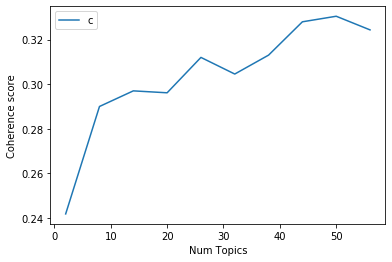

In [21]:
import os 
from gensim.models.wrappers import LdaMallet
os.environ.update({'MALLET_HOME': r'C:/Users/Isabelle/Downloads/mallet-2.0.8/mallet-2.0.8/'})
mallet_path = 'C:\\Users\\Isabelle\\Downloads\\mallet-2.0.8\\mallet-2.0.8\\bin\\mallet'

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=60, step=6)
# Show graph
limit=60; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()



In [22]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2418
Num Topics = 8  has Coherence Value of 0.29
Num Topics = 14  has Coherence Value of 0.297
Num Topics = 20  has Coherence Value of 0.2961
Num Topics = 26  has Coherence Value of 0.312
Num Topics = 32  has Coherence Value of 0.3046
Num Topics = 38  has Coherence Value of 0.3131
Num Topics = 44  has Coherence Value of 0.328
Num Topics = 50  has Coherence Value of 0.3305
Num Topics = 56  has Coherence Value of 0.3244


Looking at the above coherence values, we can see that after 38 topics the coherence begins to level off so this will be the optimal model. After this optimal model is chosen, we will then look at the topics and attempt to assign topic names. For those topics that we find interesting, we will then create word clouds associated with these topics and look into the topic frequency in documents over time.

In [27]:
optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_topics=-1, num_words=15))

[(0,
  '0.031*"donc" + 0.022*"alors" + 0.018*"faire" + 0.016*"bien" + 0.014*"oui" + '
  '0.012*"aussi" + 0.011*"terre" + 0.011*"tout" + 0.011*"petit" + '
  '0.010*"point" + 0.009*"eau" + 0.009*"dechet" + 0.008*"ca" + '
  '0.008*"plastique" + 0.008*"encore"'),
 (1,
  '0.027*"tre" + 0.024*"aussi" + 0.024*"aller" + 0.023*"ici" + 0.022*"donc" + '
  '0.020*"peu" + 0.017*"voir" + 0.016*"beaucoup" + 0.016*"pays" + 0.016*"meme" '
  '+ 0.014*"eter" + 0.014*"passer" + 0.013*"faire" + 0.012*"gens" + '
  '0.011*"oui"'),
 (2,
  '0.095*"oui" + 0.035*"alors" + 0.030*"bien" + 0.026*"bon" + 0.021*"dire" + '
  '0.019*"faire" + 0.019*"aller" + 0.017*"ca" + 0.011*"tout" + 0.010*"savoir" '
  '+ 0.010*"hein" + 0.010*"donc" + 0.009*"meme" + 0.009*"falloir" + '
  '0.009*"nc"'),
 (3,
  '0.020*"dire" + 0.018*"livre" + 0.017*"aussi" + 0.015*"faire" + 0.014*"meme" '
  '+ 0.013*"autre" + 0.011*"tre" + 0.011*"bien" + 0.011*"oui" + 0.010*"peu" + '
  '0.010*"tout" + 0.009*"vie" + 0.009*"mot" + 0.008*"beaucoup" + 0.00

In [ ]:
#Saving optimal LDA Mallet model
optimal_model.save('models/RTS_models/LDAMallet_40topics.model')

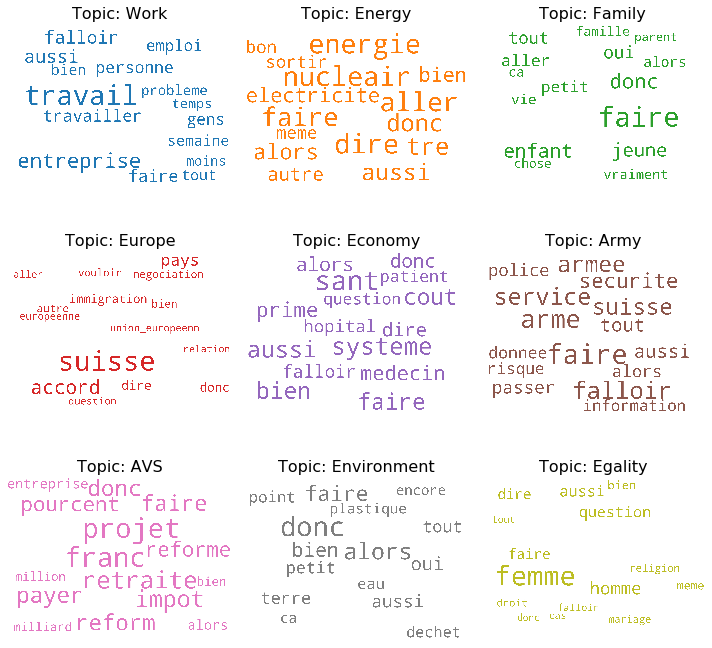

In [28]:
#Visualization of LDA topics
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords_fr,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

#Select viable topics with human assigned names
selected_topics = [8, 14, 22, 24, 36, 19, 20, 0, 12, 17]
selected_titles = ['Work', 'Energy', 'Family', 'Europe', 'Health', 'Army', 'AVS', 'Environment', 'Egality', 'Economy']

topics = optimal_model.show_topics(num_topics = -1, num_words=15, formatted=False)
topics = [topics[i] for i in selected_topics]


gs1 = gridspec.GridSpec(2, 3)
gs1.update(wspace=0.025, hspace=0.05)
fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic: ' + selected_titles[i], fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
optimal_model.show_topics(num_topics = -1, num_words = 15, formatted=False)

Below is a function for determining the dominante topic of a document.

In [49]:
#Attempt to look at the document topic distribution for the above selected topics and then this over time
def format_topics_sentences(ldamodel, corpus, all_party_data):
    # Init output
    sent_topics_df = pd.DataFrame()
    texts=all_party_data['text'].astype(str).str.lower()
    
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    sent_topics_df.reset_index(drop=True, inplace=True)
    all_party_data.reset_index(drop=True, inplace=True)
    sent_topics_df = pd.concat([sent_topics_df, all_party_data[['text', 'year']]], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, all_party_data=all_party_topic)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Year']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Year
0,0,38.0,0.2269,"falloir, aller, faire, aussi, dire, maintenant, tre, solution, beaucoup, toujours",[16.09.2019 - Modèle: vrbs_trans.fre-rts 1.0\r\n\r\nLocuteur MS1 (00:00:00) [93%] :\r\nSimonetta...,2010
1,1,10.0,0.0993,"suisse, droit, personne, faire, cas, pays, question, dire, donc, loi",[06.05.2018 - Modèle: vrbs_trans.fre-rts 1.0\r\n\r\nLocuteur MS1 (00:00:00) [89%] :\r\n7 heures ...,2010
2,2,21.0,0.1930,"dire, faire, donc, tout, bien, alors, eter, meme, guerre, mem",[08.01.2018 - Modèle: vrbs_trans.fre-rts 1.0\r\n\r\nLocuteur MS1 (00:00:00) [86%] :\r\nParce qu'...,2010
3,3,38.0,0.1688,"falloir, aller, faire, aussi, dire, maintenant, tre, solution, beaucoup, toujours",[02.11.2017 - Modèle: vrbs_trans.fre-rts 1.0\r\n\r\nLocuteur MS1 (00:00:00) [90%] :\r\nRejoint N...,2010
4,4,32.0,0.1745,"pourcent, oui, dire, eter, resultat, tre, vote, aussi, campagne, meme",[19.02.2018 - Modèle: vrbs_trans.fre-rts 1.0\r\n\r\nLocuteur FS2 (00:00:01) [70%] :\r\nNon non n...,2010
5,5,32.0,0.1866,"pourcent, oui, dire, eter, resultat, tre, vote, aussi, campagne, meme",[27.01.2018 - Modèle: vrbs_trans.fre-rts 1.0\r\n\r\nLocuteur FS2 (00:00:00) [82%] :\r\nOh non no...,2010
6,6,2.0,0.1545,"oui, alors, bien, bon, dire, faire, aller, ca, tout, savoir",[11.01.2018 - Modèle: vrbs_trans.fre-rts 1.0\r\n\r\nLocuteur MS1 (00:00:00) [82%] :\r\nDu métal ...,2010
7,7,24.0,0.1419,"suisse, accord, pays, dire, donc, immigration, autre, bien, negociation, vouloir",[17.01.2018 - Modèle: vrbs_trans.fre-rts 1.0\r\n\r\nLocuteur MS1 (00:00:00) [86%] :\r\nNicolas L...,2010
8,8,2.0,0.2352,"oui, alors, bien, bon, dire, faire, aller, ca, tout, savoir",[08.02.2016 - Modèle: vrbs_trans.fre-rts 1.0\r\n\r\nLocuteur FS2 (00:00:12) [89%] :\r\nSi aucune...,2010
9,9,36.0,0.3373,"sant, systeme, aussi, bien, faire, cout, prime, medecin, alors, donc",[16.05.2015 - Modèle: vrbs_trans.fre-rts 1.0\r\n\r\nLocuteur MS1 (00:00:00) [94%] :\r\nUne initi...,2010


In [50]:
df_dominant_topic = df_dominant_topic[df_dominant_topic['Dominant_Topic'].isin(selected_topics)]
#Want to eliminate all rows if they are not a part of the 

In [52]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_dominant_topic.groupby(['Year', 'Dominant_Topic']).count())

                     Document_No  Topic_Perc_Contrib  Keywords  Text
Year Dominant_Topic                                                 
2010 0.0                       3                   3         3     3
     8.0                       1                   1         1     1
     14.0                      2                   2         2     2
     19.0                      2                   2         2     2
     22.0                      3                   3         3     3
     24.0                      2                   2         2     2
     36.0                      1                   1         1     1
2011 0.0                       2                   2         2     2
     8.0                       5                   5         5     5
     12.0                      2                   2         2     2
     14.0                     13                  13        13    13
     19.0                      5                   5         5     5
     22.0                      2  